In [1]:
#Loading in my libraries
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt

import warnings
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in the dataset
df = pd.read_csv('social_marketing.csv')

# Change the first column name to reflect the alphanumeric code representing users
df.rename(columns={'Unnamed: 0': 'user_code'}, inplace=True)

# Remove the chatter, spam, adult, and uncategorized columns since they're unlikely to give us any relevant information
columns_to_remove = ['chatter', 'spam', 'adult', 'uncategorized']
df = df.drop(columns=columns_to_remove)

df[:3]

,user_code,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,...,automotive,art,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business
0,hmjoe4g3k,0,2,2,1,1,0,4,1,2,...,0,0,1,0,1,1,0,11,0,0
1,clk1m5w8s,3,2,1,1,4,1,2,2,1,...,0,0,0,0,0,1,4,0,0,0
2,jcsovtak3,3,4,3,5,0,2,1,1,1,...,0,8,0,1,0,1,0,0,1,0


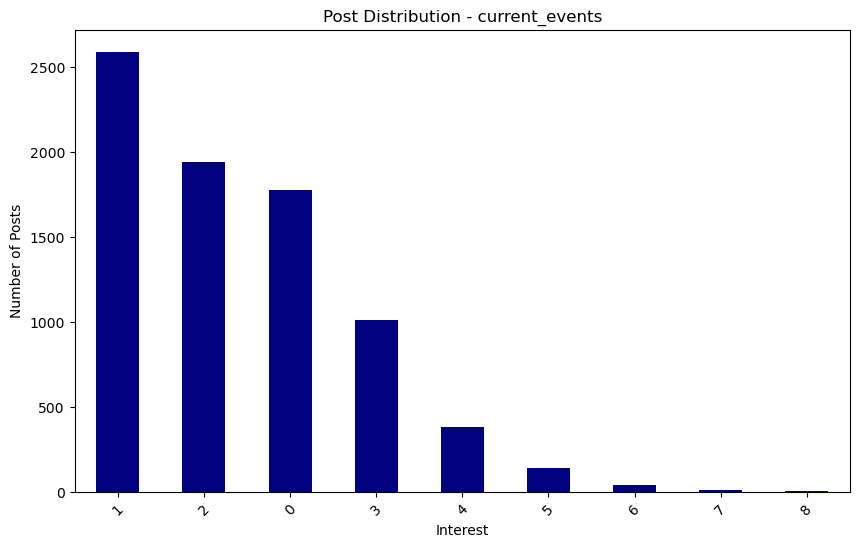

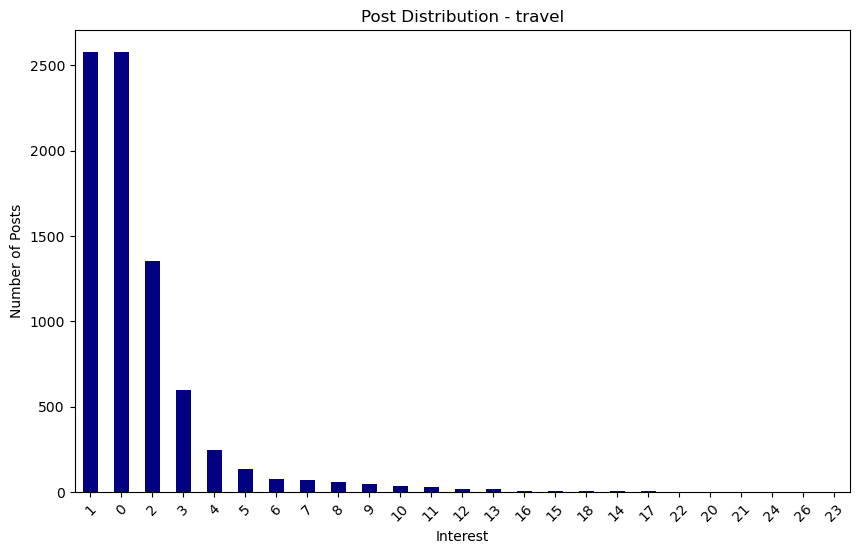

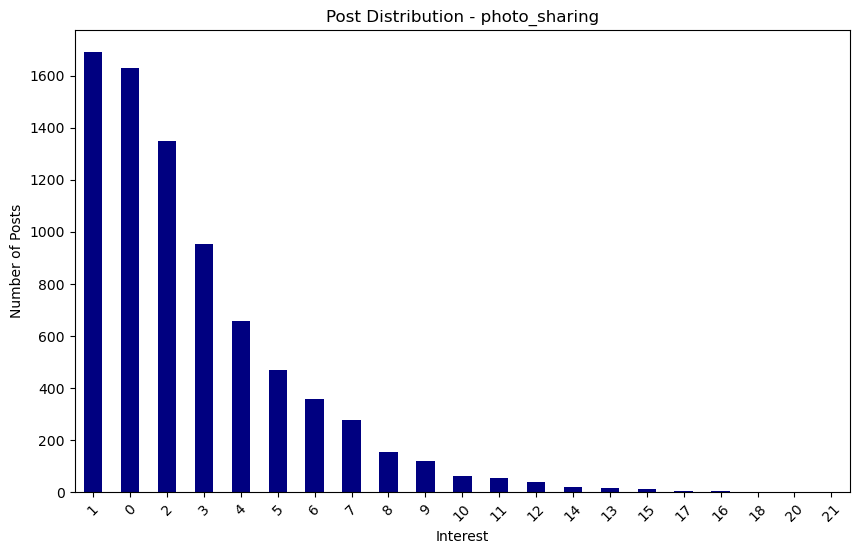

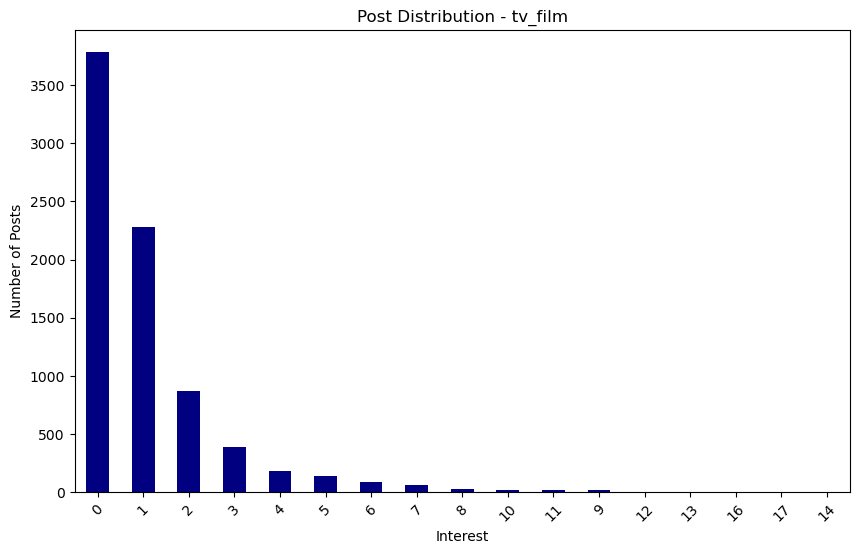

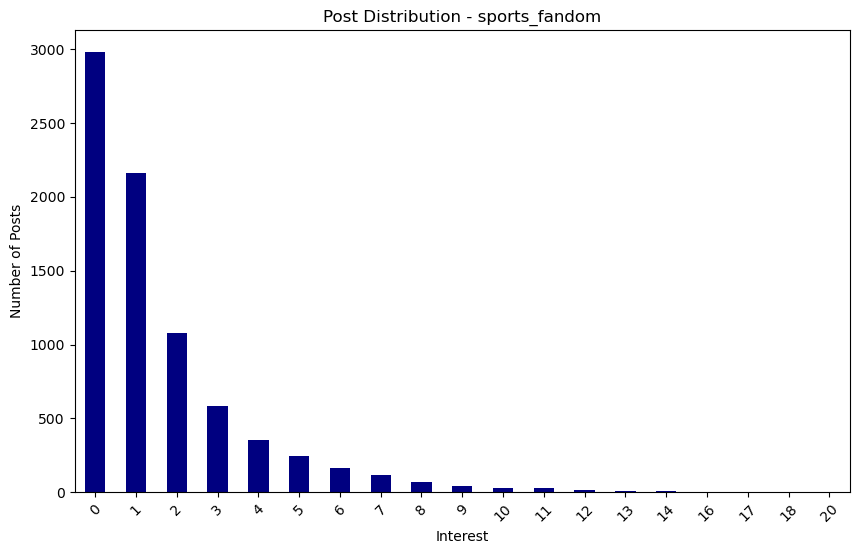

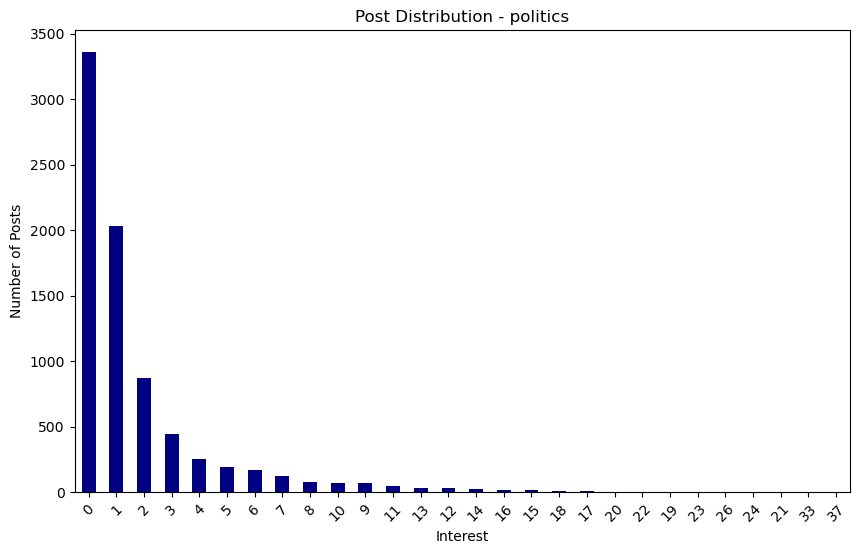

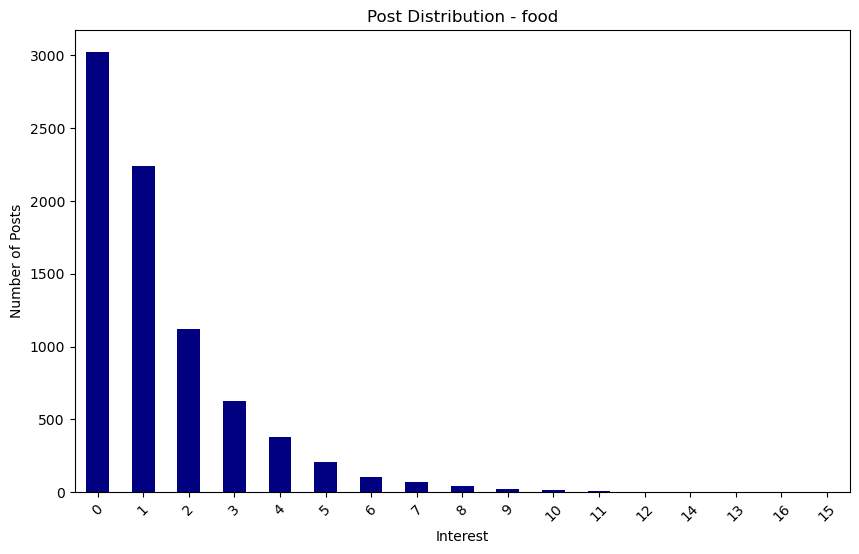

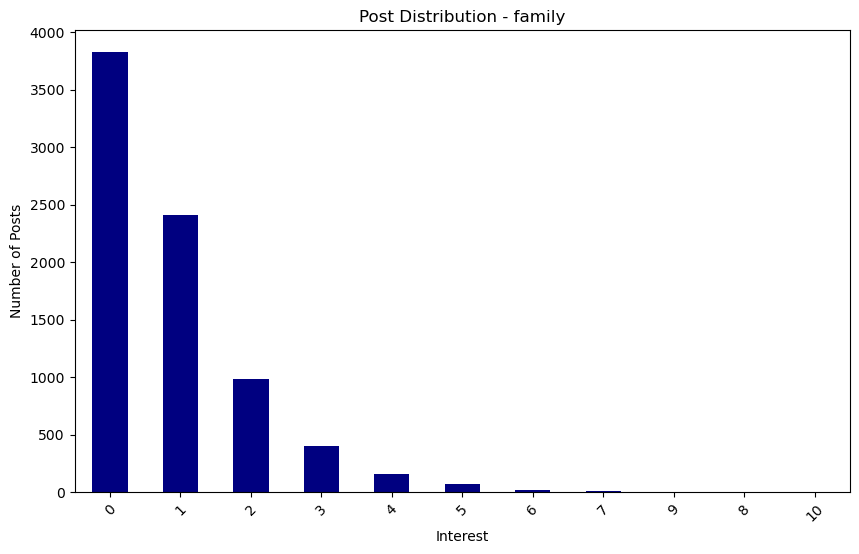

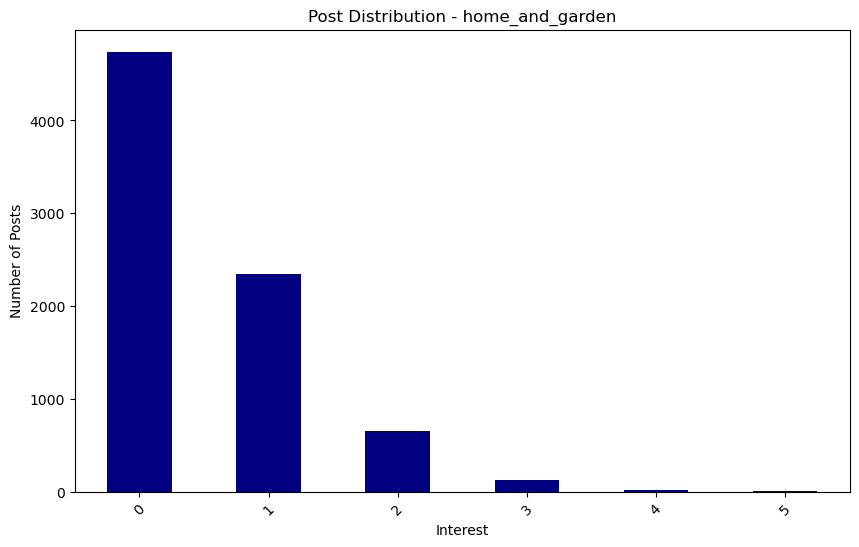

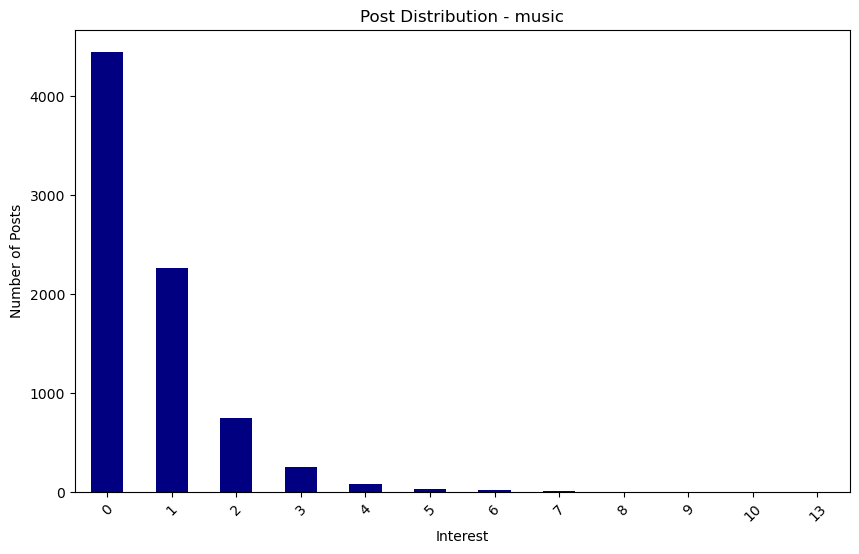

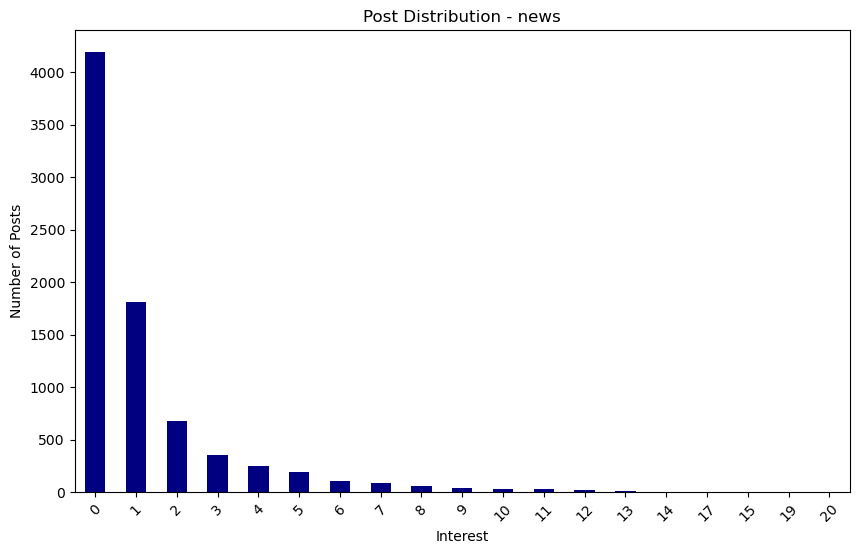

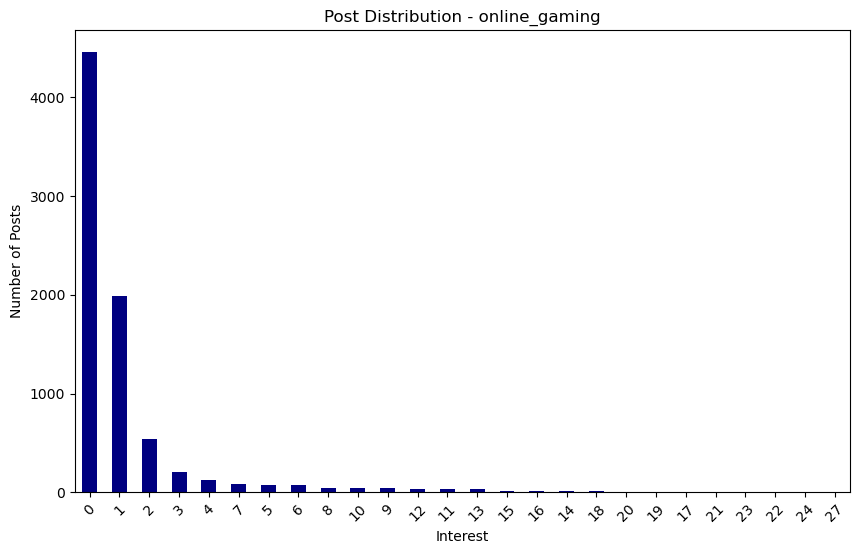

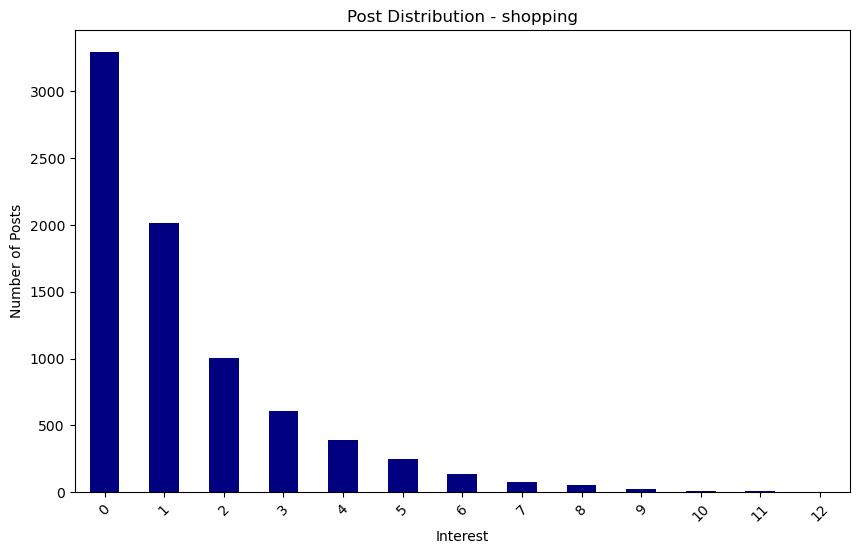

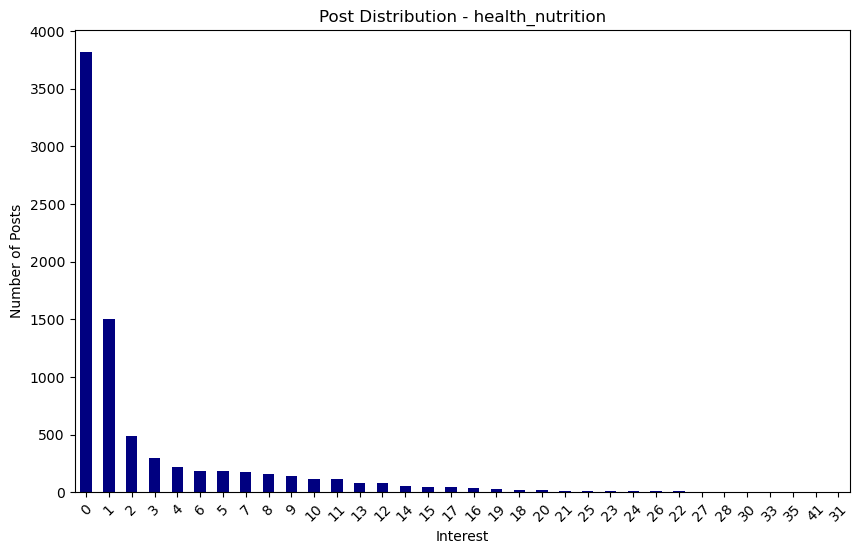

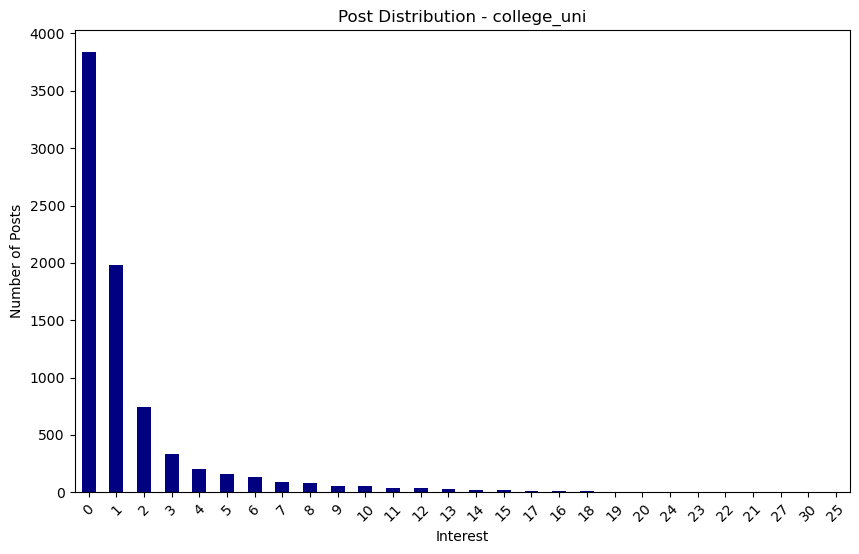

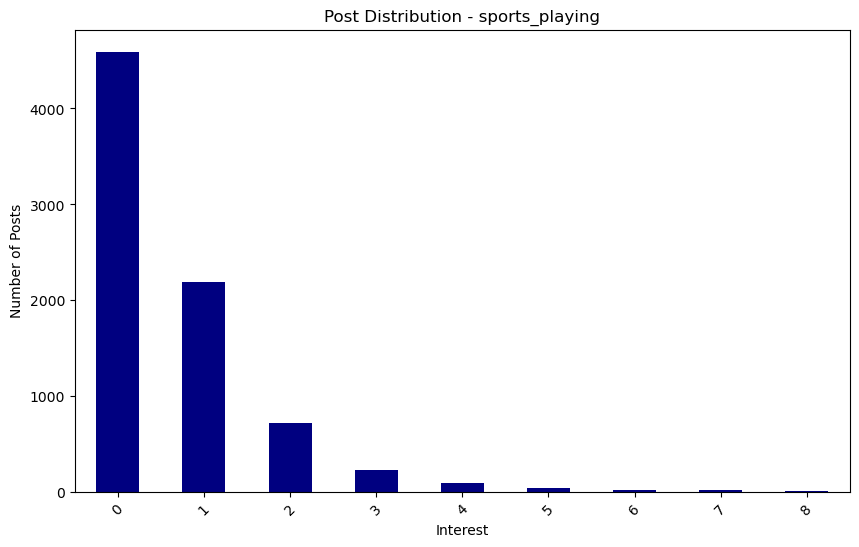

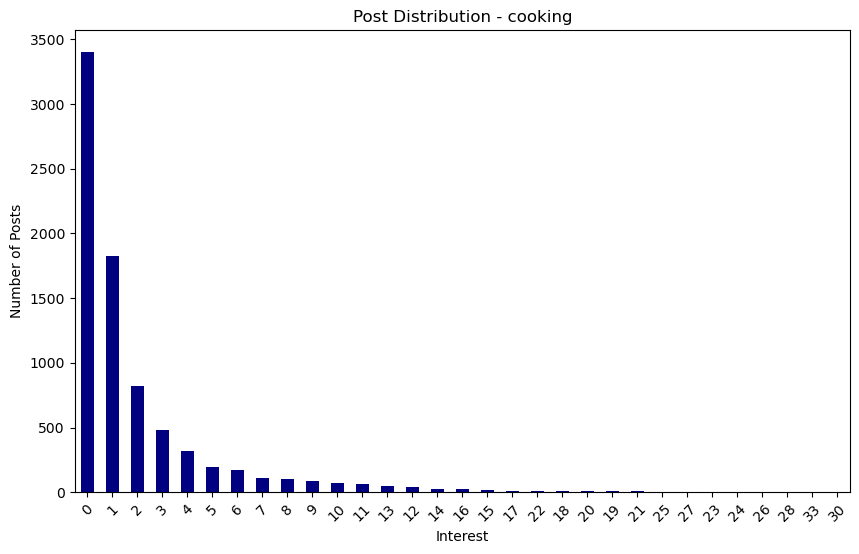

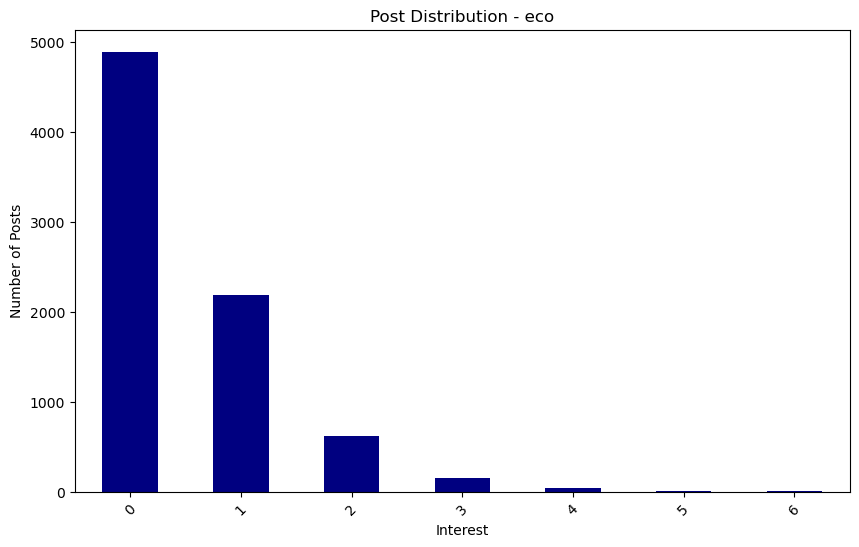

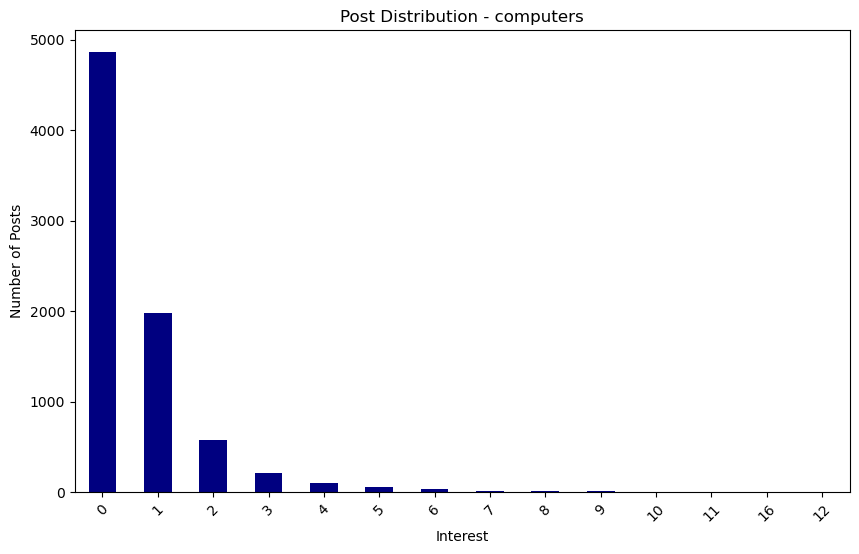

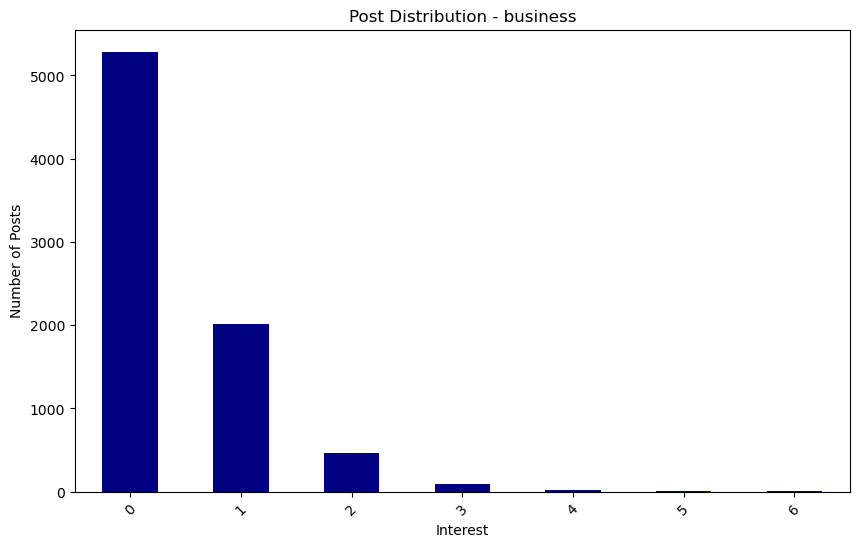

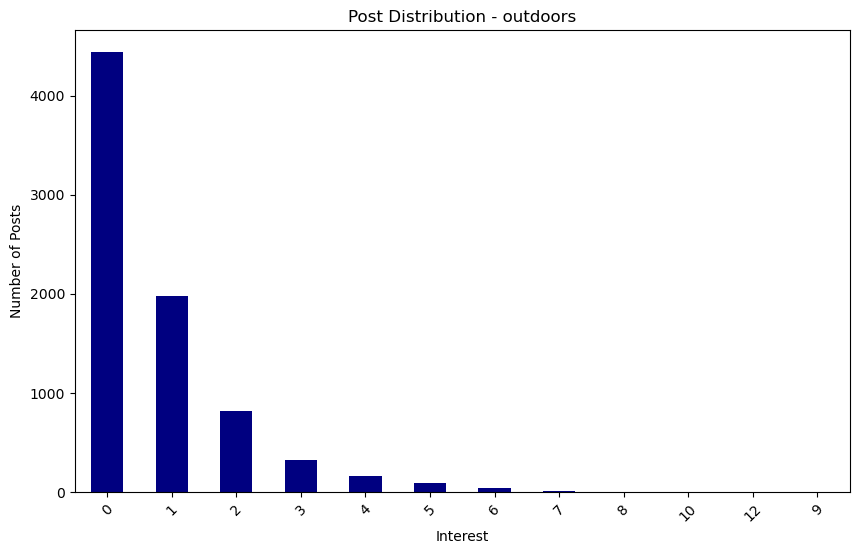

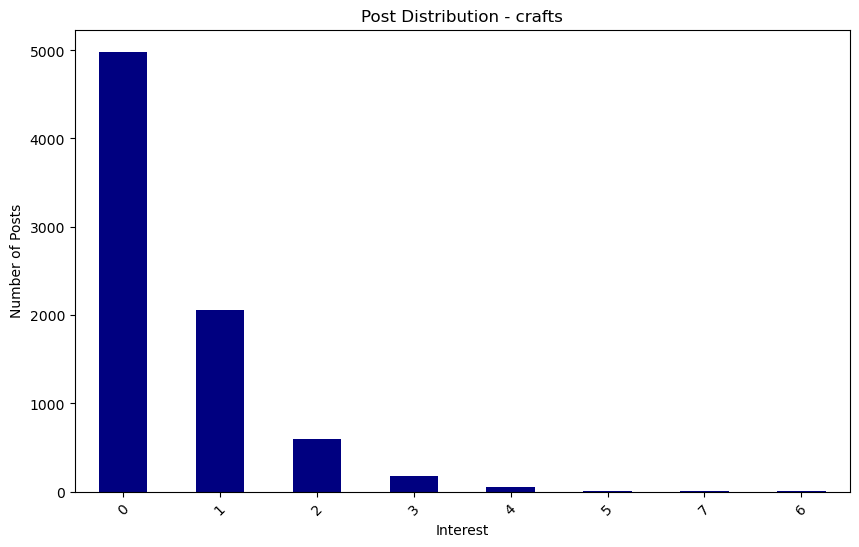

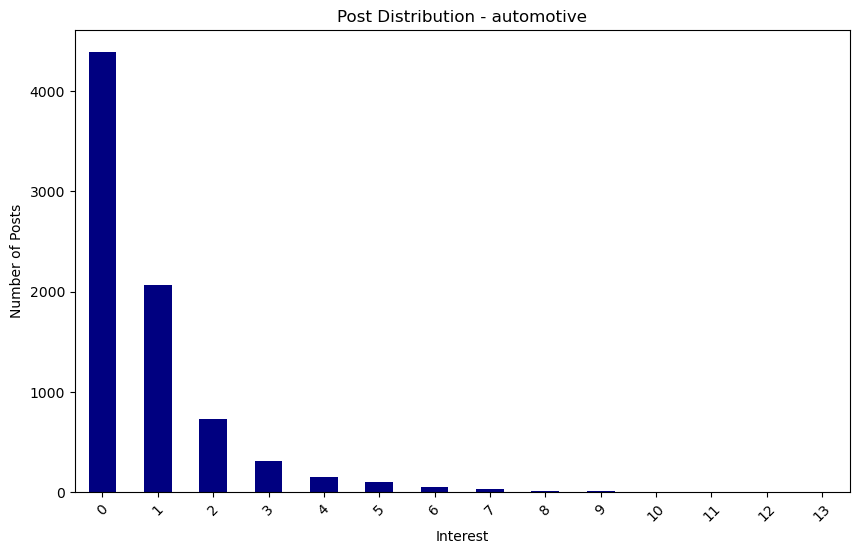

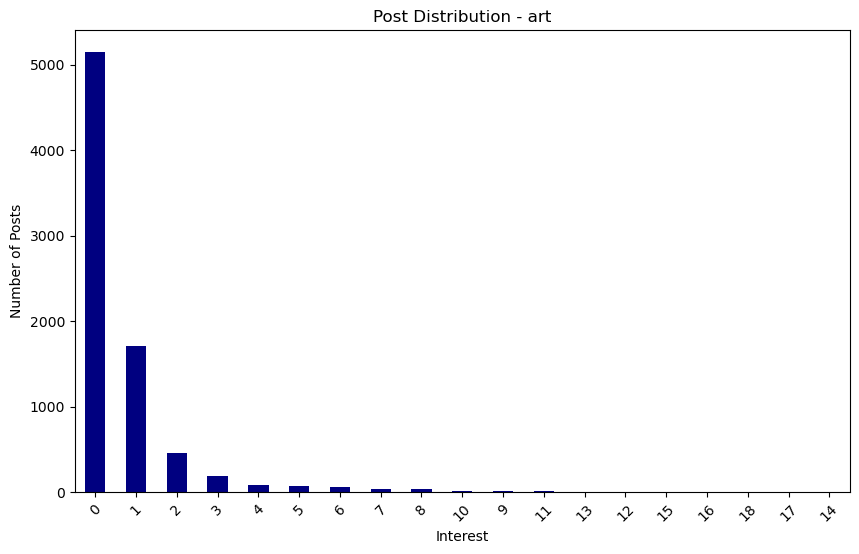

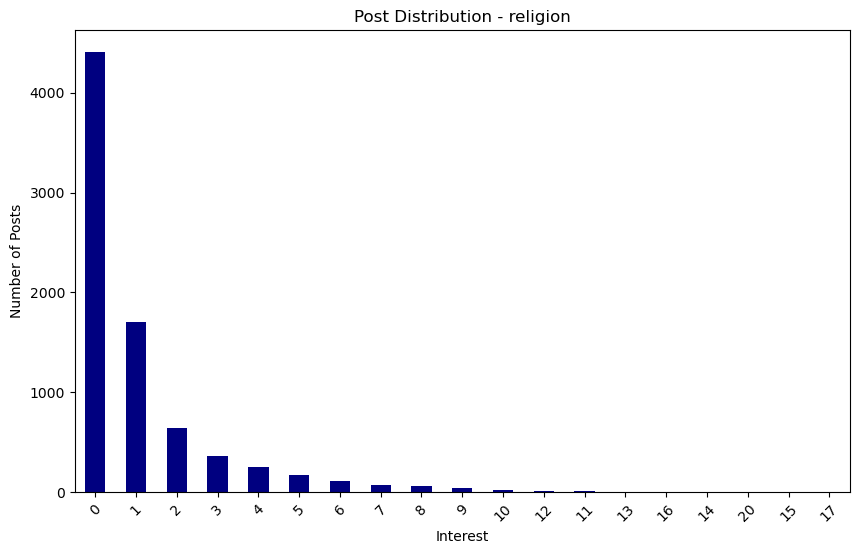

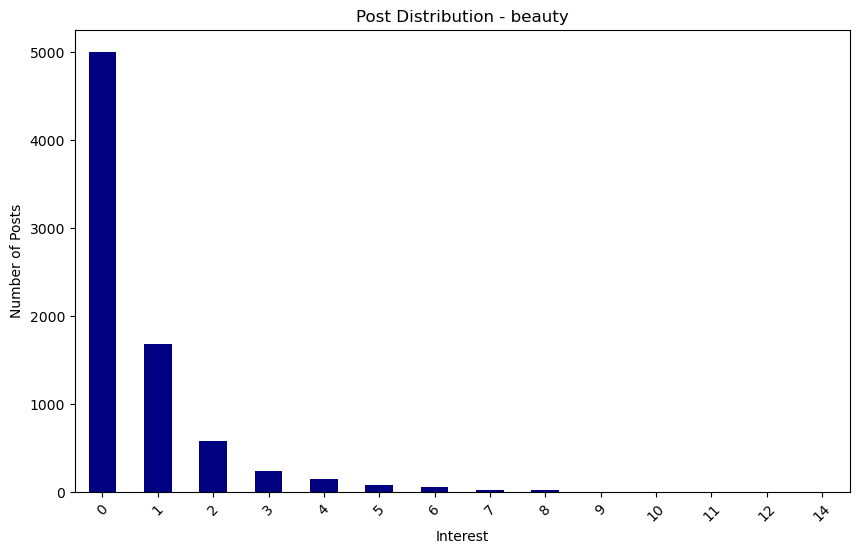

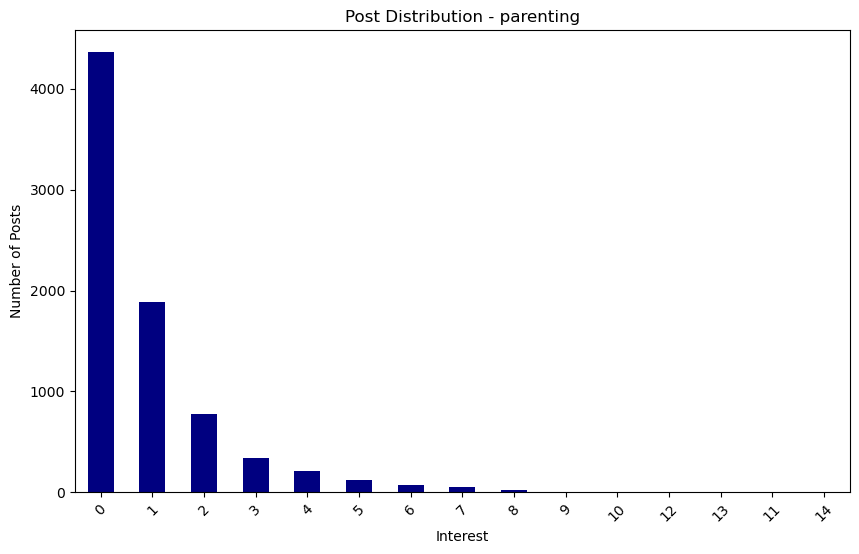

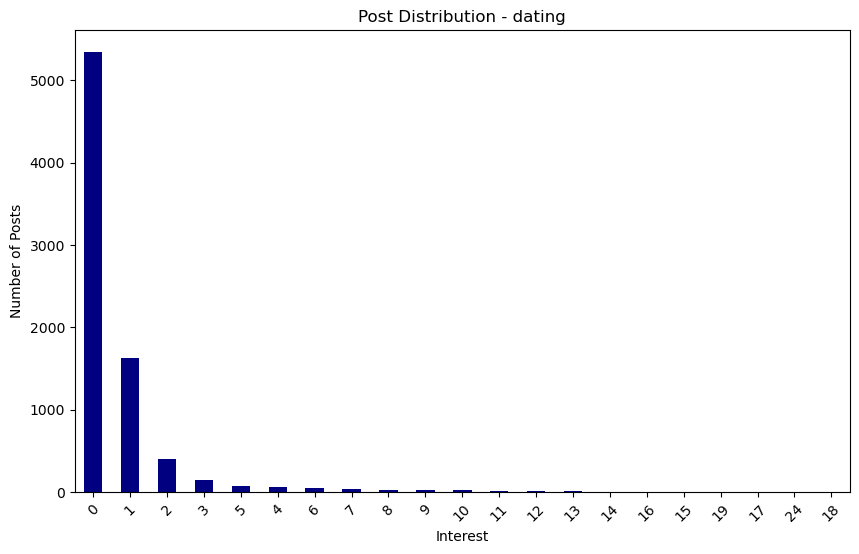

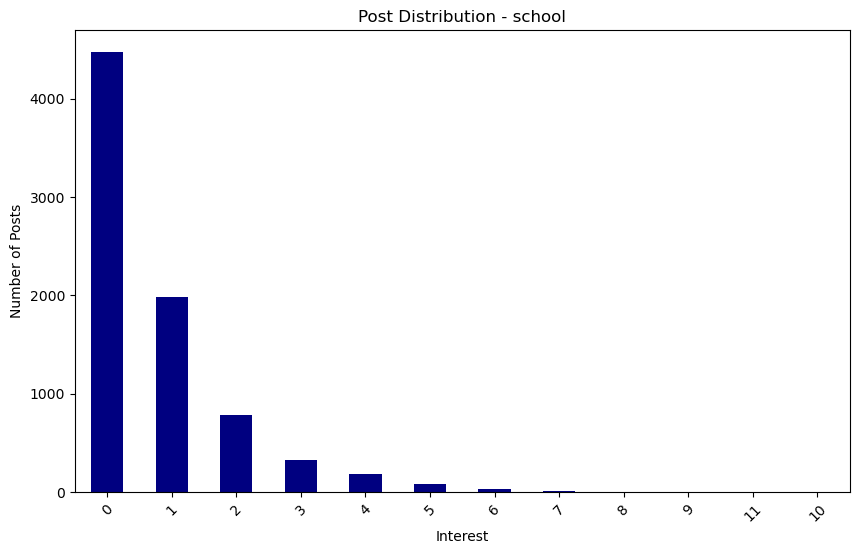

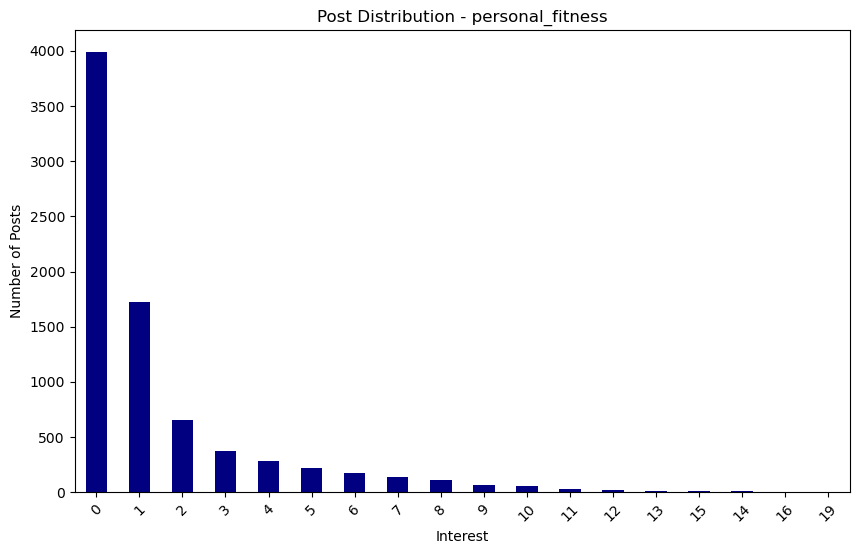

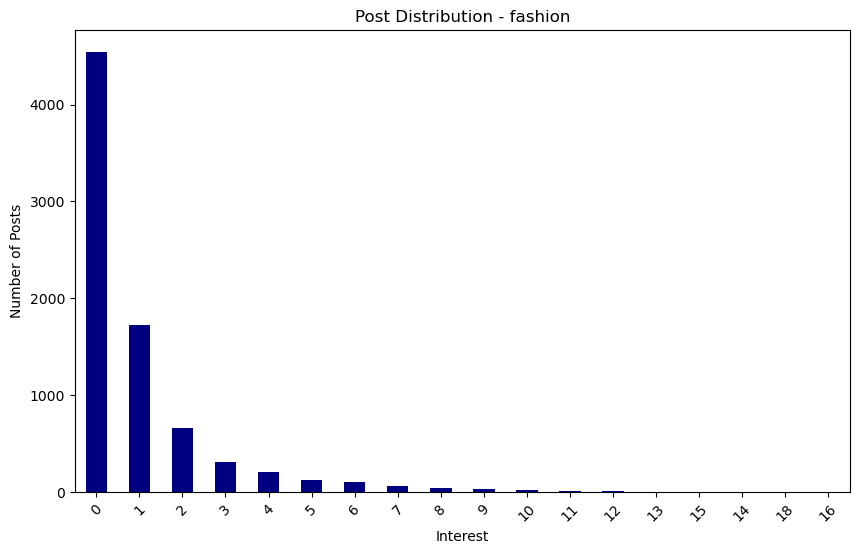

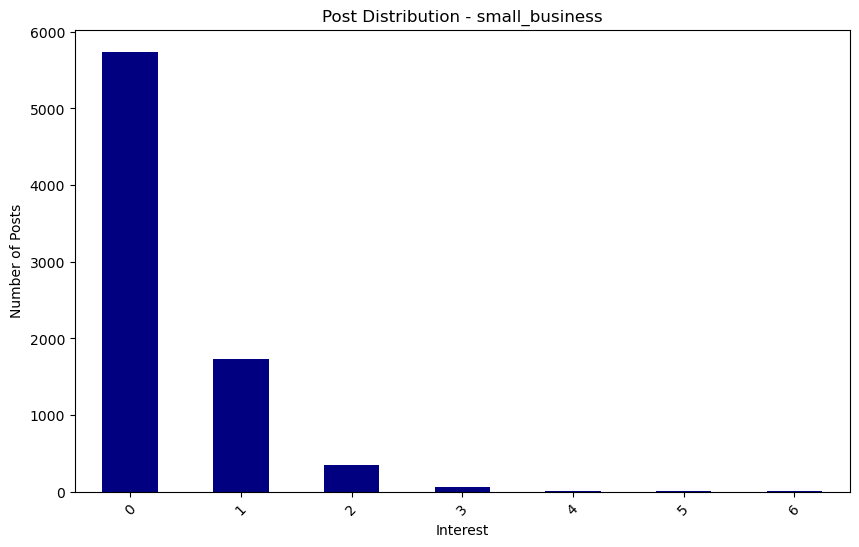

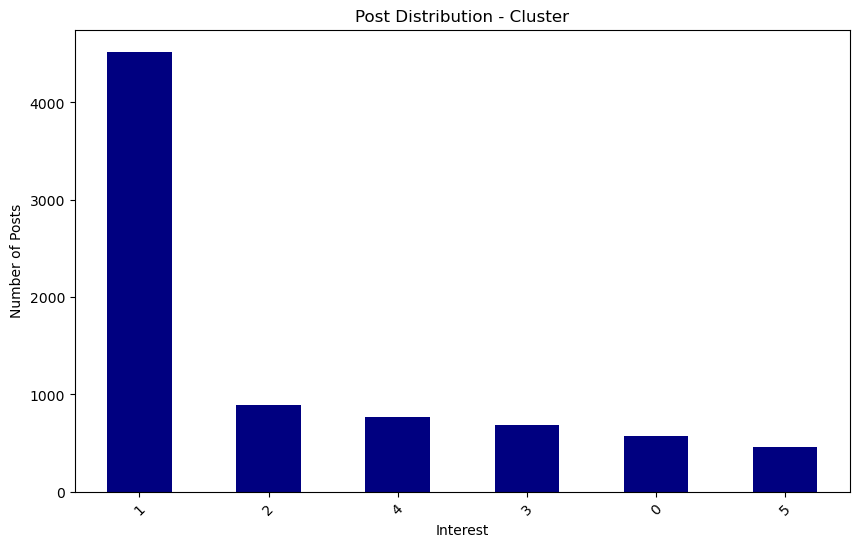

In [8]:
# Select only the interest category columns for clustering
interest_columns = df.columns[1:]
interest_data = df[interest_columns]

# Calculate frequency distributions for each interest category
frequency_distributions = {}
for column in interest_columns:
    frequency_distributions[column] = df[column].value_counts()

# Visualize the distribution of posts across different interest categories
for column, distribution in frequency_distributions.items():
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    distribution.plot(kind='bar', color='navy')
    plt.title(f"Post Distribution - {column}")
    plt.xlabel("Interest")
    plt.ylabel("Number of Posts")
    plt.xticks(rotation=45)
    plt.show()

Visualizing the distribution of posts across interests is part of my EDA in understanding the data better before doing any substantial work. Of the remaining 32 categories, the bar plots show a lot of variance between the many categories, particularly in the range of number of posts and count of posts per category. As far as the latter is concerned, some categories photo_sharing have a count of user posts as high as over 20, while posts for small_business is as low as 6.

### Clustering

I decided to define market segments through clustering and in doing so, have decided to find the amount of clusters I would need through using the elbow method.

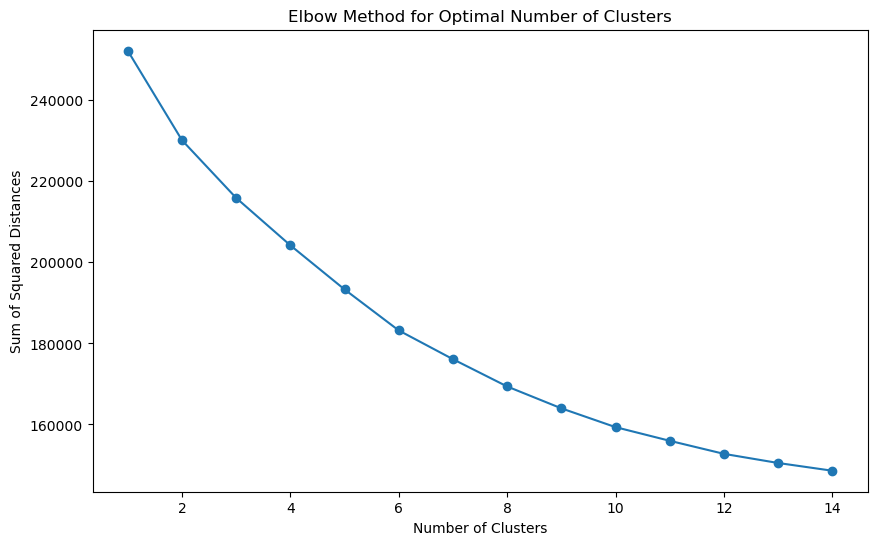

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data before clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(interest_data)

# Use the elbow method to determine the optimal number of clusters
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), sse, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()


Having completed the plot for the elbow method, it's difficult for me to pinpoint the exact spot of the "elbow point" with the visualization I have. I then decided to make another plot using silhouette score for a better comparison.

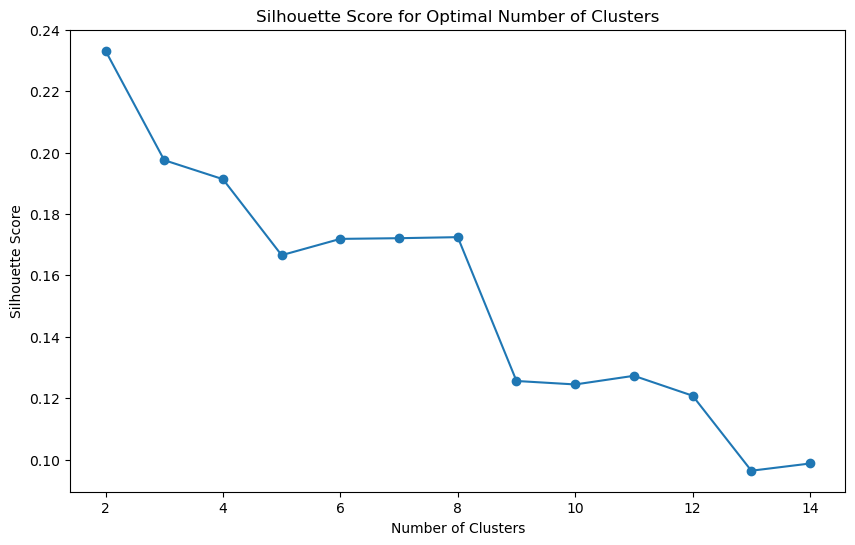

In [5]:
from sklearn.metrics import silhouette_score

# Use silhouette score to determine the optimal number of clusters
sil_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    sil_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), sil_scores, marker='o')
plt.title("Silhouette Score for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Due to the silhouette score giving a decent score between 6-8 clusters before dropping abysmally, and 6 seeming to be where the elbow point is at as well, I decided to go with a k = 6 for use in my clustering.

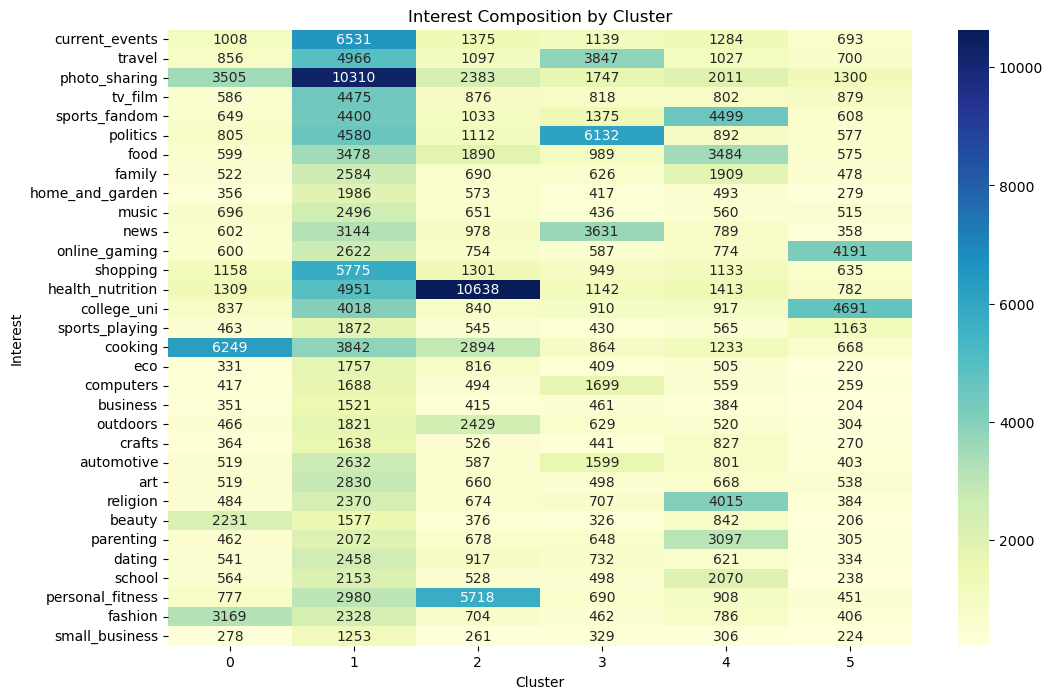

In [6]:
import seaborn as sns

# Perform k-means clustering with the chosen number of clusters
n_clusters = 6 
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
df['Cluster'] = labels

# Analyze the composition of each cluster
cluster_compositions = {}
for cluster_id in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_interests = cluster_data[interest_columns].sum()
    cluster_compositions[cluster_id] = {
        'Size': cluster_size,
        'Interests': cluster_interests
    }

# Create a DataFrame for interest composition
interest_df = pd.DataFrame([composition['Interests'] for composition in cluster_compositions.values()])

# Create a heatmap for interest composition
plt.figure(figsize=(12, 8))
sns.heatmap(interest_df.T, cmap='YlGnBu', annot=True, fmt='d')
plt.xlabel('Cluster')
plt.ylabel('Interest')
plt.title('Interest Composition by Cluster')
plt.show()

Given the clustering model I decided to make, I felt a composition heatmap would be best in portraying my results. A few details are interesting to note about each of the 6 clusters above:

Cluster 0 appears to contain users that have a strong interest in cooking, and, though slightly less, within photo-sharing, fashion and beauty as well.

Cluster 1 appears to contain users that have a very strong interest in photo-sharing, along with several other subjects such as current_events and shopping.

Cluster 2 appears to contain users that have a strong interest in health_nutrition and personal fitness.

Cluster 3 apepars to contain users that have a strong interest in politics, news, and travel.

Cluster 4 appears to contain users that have a strong interest in sports, religion, food, and parenting.

Cluster 5 appears to contain users that have a strong interest in online gaming and in colleges and universities.

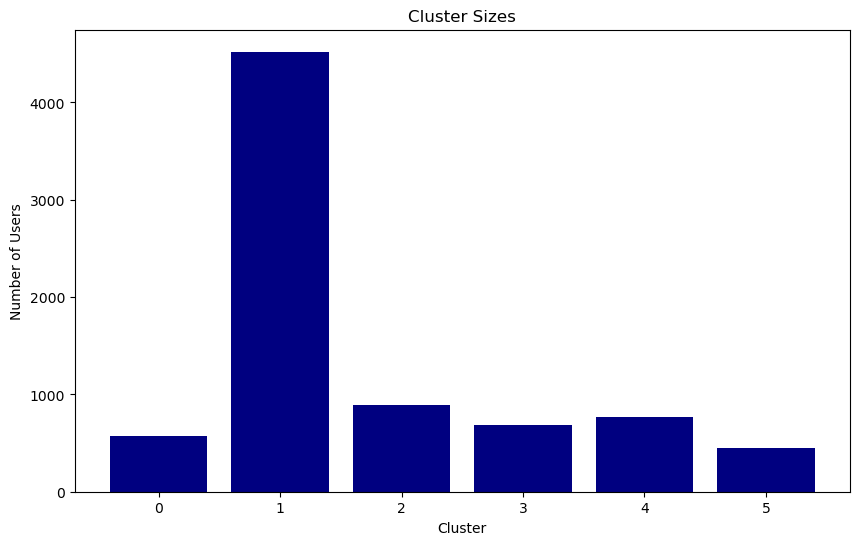

In [9]:
# Extract cluster sizes from cluster_compositions
cluster_sizes = [composition['Size'] for composition in cluster_compositions.values()]

# Create a bar plot for cluster sizes
plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), cluster_sizes, tick_label=range(n_clusters), color='navy')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Cluster Sizes')
plt.show()

Curious as to the large distribution of interests in cluster 1, I decided to make a plot to view the number of users within each cluster. the amount of users in 1 far surpass those in the other clusters. This could very well be due to the possibilty that users with a particular interest in photo-sharing tend to have interests in various other subjects as well. In fact, interest in those subjects could very well be due to users wanting to share photos of their experiences, purchases, or 
interests.

### Conclusion 

As far as identifying market segments from NutrientH2O's social-media audience goes, there's a lot of information found here. For exampe, cluster 1 has shown great interest in both shopping and photo sharing. Being a consumer brand, NutrientH2O could do marketing for products that users/consumers would want to purchase and share with others over forms of social media. A product that could catch people's eyes for example. Furthermore, there's a huge segment for nutrition and fitness in cluster 2, implying there are many users that would perhaps like a healthy, nutritional product that the company produces. As with nutrition, it could be possible to consider a market segment related to cooking as well, a large interest found in cluster 0.

Compared to information found in the other clusters, those seem to stand out the most. Of course, there are segments within those clusters that are noticeable; Politics, religion, and online gaming for example. However, they may be more difficult to market to as those segments tend to be more niche and may require specific pandering to. 